TODO:
    
- In QS, drop name
- Comment code
- Write documentation (Assumption, Description, Insights)
- 


# Homework Assignment - Data from the Web

##### Roman Bachmann, roman.bachmann@epfl.ch
##### Michael Allemann, michael.allemann@epfl.ch
##### Andrea Caforio, andrea.caforio@epfl.ch

In [1]:
%matplotlib inline

In [2]:
import requests
import json
import re
import difflib

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from bs4 import BeautifulSoup

# Constants & Helper Functions

Using the Google Chrome Postman Interceptor, we discovered, that for both the QS and the THE rankings, most of the relevant data could be found in a JSON file that was downloaded when calling the website. These files are found in the QS_DATA_URL and TH_DATA_URL below. 

For the QS ranking, the information about the students and faculty members was not contained in the JSON file, so we took the url of each university on the QS website and using BeautifulSoup extracted the four relevant numbers from the HTML of each universities QS page.

For the third part of the assignment (merging the two data frames), we encountered considerable difficulties because the two websites don't use the same name for all the universities. Thus, we had the idea to querry wikipedia with the given names and replace them by the name provided by Wikipedia. Like that, we ensure a successful join of the two data frames.

In [3]:
WIKI = 'https://en.wikipedia.org/w/index.php?search='

QS_URL = "https://www.topuniversities.com"
QS_RANK_URL = "https://www.topuniversities.com/university-rankings/world-university-rankings/2018"
QS_DATA_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"

TH_URL = "http://timeshighereducation.com"
TH_RANK_URL = "http://timeshighereducation.com/world-university-rankings/2018/world-ranking"
TH_DATA_URL = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

MAX = 200

def extract_number(tag):
    """ Retrieve a particular number value by tag within a QS
        university details page."""
    
    wrapper = uni_soup.find("div", class_=tag)
    if wrapper:
        string = wrapper.find("div", class_="number").text[1:]
        return int(re.sub("[^0-9^.]", "", string))
    else:
        return np.nan
    
def wiki_name(uni):
    """ Retrieve the university name as stated on Wikipedia."""
    
    name = uni.strip().replace(' ', '+')
    req = requests.get(WIKI + name)
    soup = BeautifulSoup(req.text, 'html.parser')
    header = soup.find("h1", {"id": "firstHeading"})
    if (header.get_text() == 'Search results'):
        entry = soup.find('div', {'class': 'mw-search-result-heading'})
        return entry.get_text().strip()
    else:
        return header.get_text().strip()

## 1. 200 QS Top Universities from www.topuniversities.com 

As mentioned above, for the QS website, we extracted most relevant information from a JSON file and filled in the rest by scraping the HTML of the details pages of each university. We did this by applying what we learned in the tutorial about webscraping.

In [4]:
# Get the JSON file with the university data
QS_data_req = requests.get(QS_DATA_URL)
QS_data = QS_data_req.json()

QS_ranking = pd.DataFrame(columns = ["title", "rank_display", "country", "region"])

for i in range(MAX):
    # Load relevant data from i-th univerity into a Pandas data frame
    df_i = pd.DataFrame.from_dict(QS_data["data"][i], orient='index').T
    df_i = df_i.drop(["stars", "guide", "cc", "logo", "core_id", "url", "nid", "score"], axis=1)
        
    # Rename the university name to the corresponding name given by Wikipedia
    df_i['title'] = wiki_name(df_i.title[0])
    
    # Request the details page of the i-th university
    uni_url = QS_URL + QS_data["data"][i]["url"]
    uni_request = requests.get(uni_url)
    uni_page_body = uni_request.text
    uni_soup = BeautifulSoup(uni_page_body, 'html.parser')
    
    # Extract data about students and faculty members from the details page
    df_i["total_students"] = extract_number("total student")
    df_i["inter_students"] = extract_number("total inter")
    df_i["faculty_members"] = extract_number("total faculty")
    df_i["inter_faculty_members"] = extract_number("inter faculty")
    
    # Compute the ratios of faculty members and international students to total students
    df_i["ratio_faculty"] = df_i["faculty_members"] / df_i["total_students"]
    df_i["ratio_international"] = df_i["inter_students"] / df_i["total_students"]
    QS_ranking = QS_ranking.append(df_i)    

QS_ranking = QS_ranking.rename(columns = {'title':'name'})
QS_ranking = QS_ranking.set_index('name', drop=False)
QS_ranking = QS_ranking.add_suffix('_QS')

In [5]:
QS_ranking.head()

,country_QS,faculty_members_QS,inter_faculty_members_QS,inter_students_QS,rank_display_QS,ratio_faculty_QS,ratio_international_QS,region_QS,name_QS,total_students_QS
name,,,,,,,,,,
Massachusetts Institute of Technology,United States,2982.0,1679.0,3717.0,1,0.269450,0.335863,North America,Massachusetts Institute of Technology,11067.0
Stanford University,United States,4285.0,2042.0,3611.0,2,0.269870,0.227422,North America,Stanford University,15878.0
Harvard University,United States,4350.0,1311.0,5266.0,3,0.193945,0.234785,North America,Harvard University,22429.0
California Institute of Technology,United States,953.0,350.0,647.0,4,0.422616,0.286918,North America,California Institute of Technology,2255.0
University of Cambridge,United Kingdom,5490.0,2278.0,6699.0,5,0.292488,0.356899,Europe,University of Cambridge,18770.0


In [6]:
QS_ranking.describe()

,faculty_members_QS,inter_faculty_members_QS,inter_students_QS,ratio_faculty_QS,ratio_international_QS,total_students_QS
count,199.000000,198.000000,199.000000,199.000000,199.000000,199.000000
mean,2912.949749,786.409091,5078.261307,0.125954,0.210753,25709.130653
std,2010.741417,666.690652,3924.655224,0.060456,0.116623,17135.556845
min,86.000000,1.000000,47.000000,0.040391,0.009892,532.000000
25%,1636.500000,327.000000,2552.500000,0.084660,0.121595,15140.500000
50%,2605.000000,599.500000,4250.000000,0.115207,0.194168,23775.000000
75%,3633.500000,1027.750000,6880.500000,0.148536,0.280237,32216.000000
max,16421.000000,3905.000000,27109.000000,0.422616,0.691393,141939.000000


We observe that there are only 199 values for the faculty members and number of students. This is because the New York Universities QS page does not contain any information about those numbers.

### 1.a) Best university in terms of ratio between faculty members and students

We assume that the "best" university is the one with the most faculty members per student. The following bar chart shows the 10 best universities in that category, according to the numbers provided by the QS ranking:

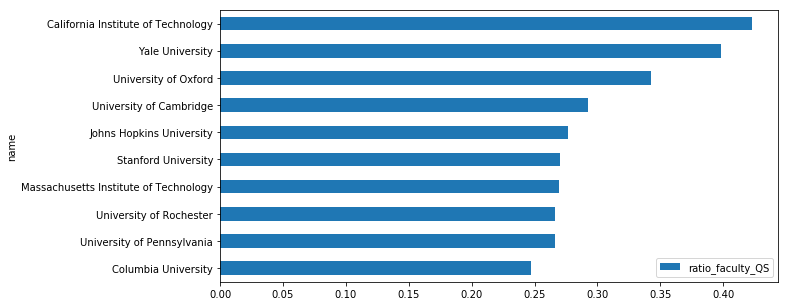

In [7]:
QS_ranking[["ratio_faculty_QS"]].sort_values("ratio_faculty_QS", ascending=False) \
    .head(10).plot.barh(figsize=(10,5)).invert_yaxis()

### 1.b) Best university in terms of ratio of international students to total students

We assume that the "best" university is the one with the most international students compared to the total number of student. The following bar chart shows the 10 best universities in that category, according to the numbers provided by the QS ranking:

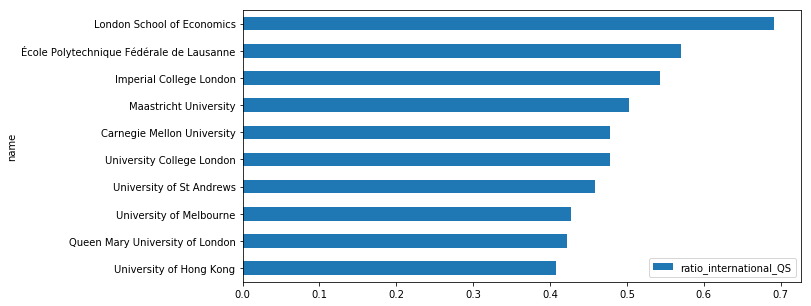

In [8]:
QS_ranking[["ratio_international_QS"]].sort_values("ratio_international_QS", ascending=False) \
    .head(10).plot.barh(figsize=(10,5)).invert_yaxis()

### 1.c) Best by country

#### Best universities in terms of ratio between faculty members and students (by country)

To get a sense for the best universities in each country, in terms of the ratio of faculty members to students, we sort the QS data frame by the countries and the ratio.

In [9]:
faculty_country_df = QS_ranking.set_index(["country_QS", "name_QS"])
faculty_country_df = faculty_country_df[["ratio_faculty_QS"]]
faculty_country_df = faculty_country_df.sort_values(["ratio_faculty_QS"], ascending=False)
faculty_country_df = faculty_country_df.sort_index(level="country_QS",sort_remaining=False)
faculty_country_df.head()

ratio_faculty_QS
country_QS name_QS                                         
Argentina  University of Buenos Aires              0.134267
Australia  Australian National University          0.110788
           University of Queensland                0.084220
           University of Adelaide                  0.081403
           University of Melbourne                 0.078493

#### Best university in terms of ratio of international students to total students (by country)

To get a sense for the best universities in each country, in terms of the ratio of international students to the number of total students, we sort the QS data frame by the countries and the ratio.

In [10]:
inter_country_df = QS_ranking.set_index(["country_QS", "name_QS"])
inter_country_df = inter_country_df[["ratio_international_QS"]]
inter_country_df = inter_country_df.sort_values(["ratio_international_QS"], ascending=False)
inter_country_df = inter_country_df.sort_index(level="country_QS",sort_remaining=False)
inter_country_df.head()

ratio_international_QS
country_QS name_QS                                               
Argentina  University of Buenos Aires                    0.221658
Australia  University of Melbourne                       0.427434
           Australian National University                0.384365
           University of Adelaide                        0.382015
           University of Sydney                          0.364840

#### Best countries in terms of ratio between faculty members and students

Here, we group the universities by country and aggregate the mean ratio of faculty members to students and plot the resulting numbers in descending order. The displayed black error bars indicate the standard deviation of the ratios for all universities in a given country.

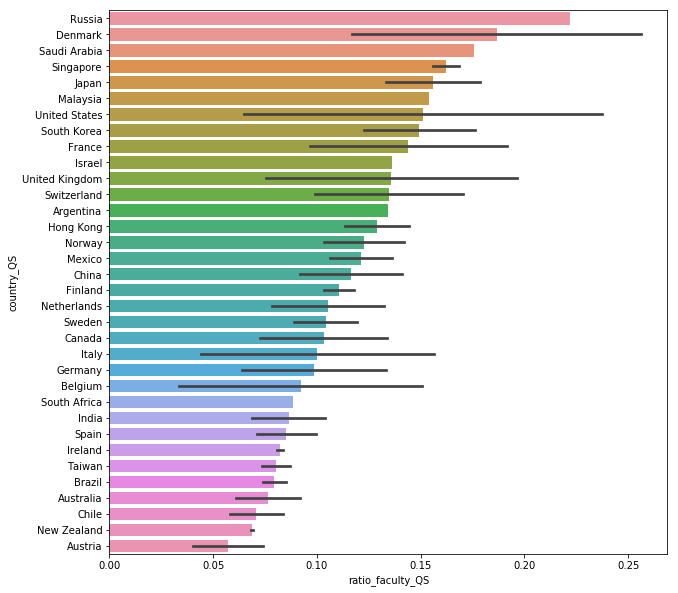

In [11]:
best_faculty_country = faculty_country_df.groupby("country_QS").mean().sort_values("ratio_faculty_QS", ascending=False)
best_faculty_country = best_faculty_country.rename(columns = {"ratio_faculty_QS": "ratio_faculty_QS_mean"})
best_faculty_country = best_faculty_country.reset_index()
best_faculty_country = QS_ranking.merge(best_faculty_country)
best_faculty_country = best_faculty_country.sort_values("ratio_faculty_QS_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax, y="country_QS", x="ratio_faculty_QS", data=best_faculty_country, orient="h",ci='sd')

#### Best countries in terms of ratio between international students and total number of students

Here, we group the universities by country and aggregate the mean ratio of international students and total number of students and plot the resulting numbers in descending order. The displayed black error bars indicate the standard deviation of the ratios for all universities in a given country.

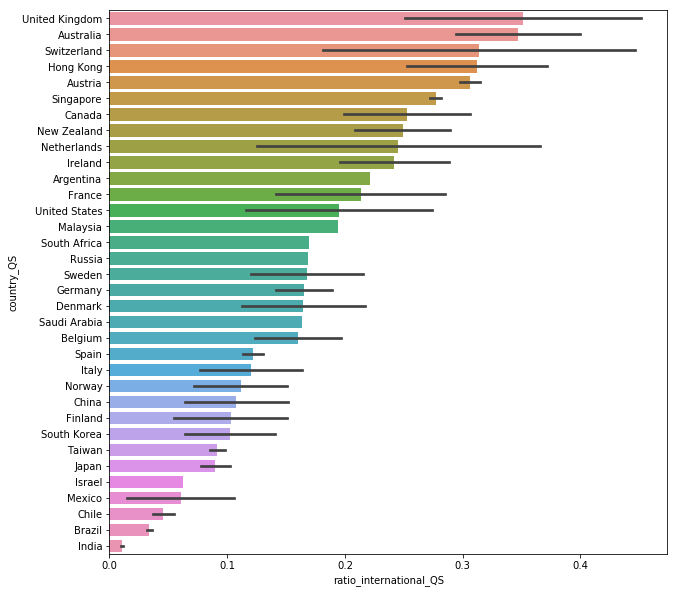

In [12]:
best_inter_country = inter_country_df.groupby("country_QS").mean().sort_values("ratio_international_QS", ascending=False)
best_inter_country = best_inter_country.rename(columns = {"ratio_international_QS": "ratio_international_QS_mean"})
best_inter_country = best_inter_country.reset_index()
best_inter_country = QS_ranking.merge(best_inter_country)
best_inter_country = best_inter_country.sort_values("ratio_international_QS_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax, y="country_QS", x="ratio_international_QS", data=best_inter_country, orient="h", ci="sd")

### 1.d) Best by region

#### Best university in terms of ratio between faculty members and students (by region)

To get a sense for the best universities in each region, in terms of the ratio of faculty members to students, we sort the QS data frame by the regions and the ratio.

In [13]:
faculty_region_df = QS_ranking.set_index(["region_QS", "name_QS"])
faculty_region_df = faculty_region_df[["ratio_faculty_QS"]]
faculty_region_df = faculty_region_df.sort_values(["ratio_faculty_QS"], ascending=False)
faculty_region_df = faculty_region_df.sort_index(level="region_QS",sort_remaining=False)
faculty_region_df.head()

ratio_faculty_QS
region_QS name_QS                                                         
Africa    University of Cape Town                                 0.088450
Asia      Pohang University of Science and Technology             0.213025
          Tohoku University                                       0.191339
          Kyoto University                                        0.176722
          King Fahd University of Petroleum and Minerals          0.175828

#### Best university in terms of ratio of international students to total students (by region)

To get a sense for the best universities in each region, in terms of the ratio of international students to total students, we sort the QS data frame by the regions and the ratio.

In [14]:
inter_region_df = QS_ranking.set_index(["region_QS", "name_QS"])
inter_region_df = inter_region_df[["ratio_international_QS"]]
inter_region_df = inter_region_df.sort_values(["ratio_international_QS"], ascending=False)
inter_region_df = inter_region_df.sort_index(level="region_QS",sort_remaining=False)
inter_region_df.head()

ratio_international_QS
region_QS name_QS                                                               
Africa    University of Cape Town                                       0.169703
Asia      University of Hong Kong                                       0.407144
          City University of Hong Kong                                  0.354221
          Nanyang Technological University                              0.281724
          Hong Kong University of Science and Technology                0.281542

#### Best regions in terms of ratio between faculty members and students

Here, we group the universities by region and aggregate the mean ratio of faculty members to students and plot the resulting numbers in descending order. The displayed black error bars indicate the standard deviation of the ratios for all universities in a given region.

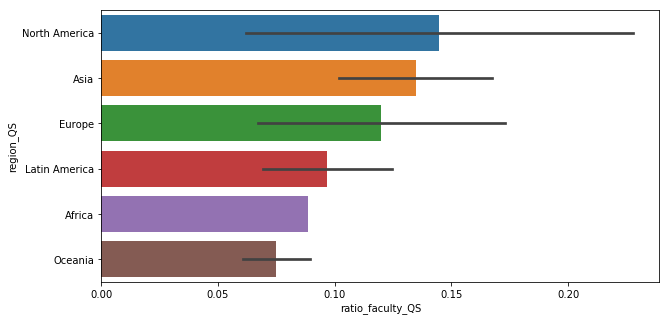

In [15]:
best_faculty_region = faculty_region_df.groupby("region_QS").mean().sort_values("ratio_faculty_QS", ascending=False)
best_faculty_region = best_faculty_region.rename(columns = {"ratio_faculty_QS": "ratio_faculty_QS_mean"})
best_faculty_region = best_faculty_region.reset_index()
best_faculty_region = QS_ranking.merge(best_faculty_region)
best_faculty_region = best_faculty_region.sort_values("ratio_faculty_QS_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, y="region_QS", x="ratio_faculty_QS", data=best_faculty_region, orient="h", ci="sd")

#### Best regions in terms of ratio between international students and total number of students

Here, we group the universities by region and aggregate the mean ratio of international students and total number of students and plot the resulting numbers in descending order. The displayed black error bars indicate the standard deviation of the ratios for all universities in a given region.

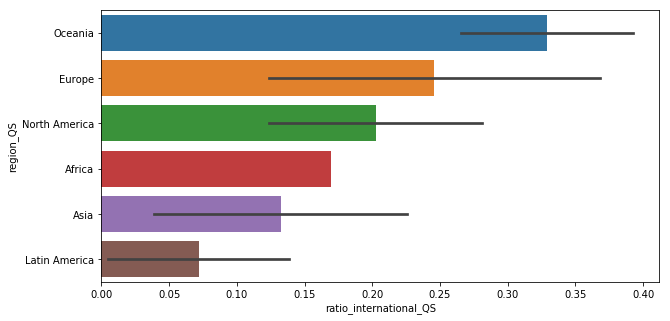

In [16]:
best_inter_region = inter_region_df.groupby("region_QS").mean().sort_values("ratio_international_QS", ascending=False)
best_inter_region = best_inter_region.rename(columns = {"ratio_international_QS": "ratio_international_QS_mean"})
best_inter_region = best_inter_region.reset_index()
best_inter_region = QS_ranking.merge(best_inter_region)
best_inter_region = best_inter_region.sort_values("ratio_international_QS_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, y="region_QS", x="ratio_international_QS", data=best_inter_region, orient="h", ci="sd")

## 2. 200 THE Top Universities from www.timeshighereducation.com

As mentioned above, for the THE website, we extracted all the relevant information from a JSON file. We did this by applying what we learned in the tutorial about webscraping.

In [17]:
# Get the JSON file with the university data
TH_data_req = requests.get(TH_DATA_URL)
TH_data = TH_data_req.json()

TH_ranking = pd.DataFrame(columns = ["name", "rank", "location"])

for i in range(MAX):
    # Load relevant data from i-th univerity into a Pandas data frame
    df_i = pd.DataFrame.from_dict(TH_data["data"][i], orient='index').T
    drop_cols = df_i.columns.difference(["name", "rank", "location"])
    df_i = df_i.drop(drop_cols, axis=1)
        
    # Rename the university name to the corresponding name given by Wikipedia
    df_i['name'] = wiki_name(df_i.name[0])
    
    # Extract data about students
    df_i["total_students"] = int(re.sub("[^0-9^.]", "", TH_data["data"][i]["stats_number_students"]))
    percentage_intl = int(re.sub("[^0-9^.]", "", TH_data["data"][i]["stats_pc_intl_students"]))
    df_i["ratio_international"] = percentage_intl / 100
    df_i["international_students"] = int(df_i.total_students * percentage_intl / 100)
    
    # Get the region based on the region of the country in the QS ranking
    country = TH_data["data"][i]["location"]
    
    reg = QS_ranking.loc[QS_ranking['country_QS'] == country]['region_QS']
    df_i['region'] = reg.iloc[0] if len(reg) > 0 else np.nan
    
    TH_ranking = TH_ranking.append(df_i)
    

TH_ranking = TH_ranking.set_index("name", drop=False)
TH_ranking = TH_ranking.add_suffix("_TH")

In [18]:
TH_ranking.head()

,international_students_TH,location_TH,name_TH,rank_TH,ratio_international_TH,region_TH,total_students_TH
name,,,,,,,
University of Oxford,7755.0,United Kingdom,University of Oxford,1,0.38,Europe,20409.0
University of Cambridge,6436.0,United Kingdom,University of Cambridge,2,0.35,Europe,18389.0
California Institute of Technology,596.0,United States,California Institute of Technology,=3,0.27,North America,2209.0
Stanford University,3485.0,United States,Stanford University,=3,0.22,North America,15845.0
Massachusetts Institute of Technology,3800.0,United States,Massachusetts Institute of Technology,5,0.34,North America,11177.0


In [19]:
TH_ranking.describe()

,international_students_TH,ratio_international_TH,total_students_TH
count,200.000000,200.000000,200.00000
mean,4964.715000,0.218650,24746.29500
std,3108.431593,0.115657,13353.01984
min,36.000000,0.030000,515.00000
25%,2789.000000,0.130000,14880.25000
50%,4437.500000,0.190000,23130.50000
75%,6693.500000,0.280000,32933.25000
max,16846.000000,0.710000,69427.00000


### 2.a) Best university in terms of ratio between faculty members and students

The staff ratio provided by the THE data set is the number of students per staff, which is not the same as the ratio between faculty members and students. We assume that in the staff ratio, service personell is included, thus we cannot infer the ratio between faculty members and students for this data set.

### 2.b) Best university in terms of ratio of international students to total students

We assume that the "best" university is the one with the most international students compared to the total number of student. The following bar chart shows the 10 best universities in that category, according to the numbers provided by the THE ranking:

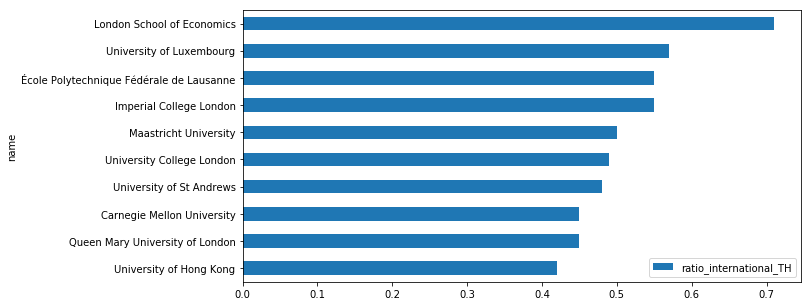

In [20]:
TH_ranking[["ratio_international_TH"]].sort_values("ratio_international_TH", ascending=False) \
    .head(10).plot.barh(figsize=(10,5)).invert_yaxis()

If we compare the top 10 of both the QS and the THE rankings, we observe that they seem to have different values for the same statistic. A reasen herefor could be that QS and THE used data from different academic years or that their method of counting is different.

### 2.c) Best by country

#### Best universities in terms of ratio between faculty members and students (by country)

No data available - refer to 2.a)

#### Best university in terms of ratio of international students to total students (by country)

To get a sense for the best universities in each country, in terms of the ratio of international students to the number of total students, we sort the THE data frame by the countries and the ratio.

In [21]:
inter_country_df_TH = TH_ranking.set_index(["location_TH", "name_TH"])
inter_country_df_TH = inter_country_df_TH[["ratio_international_TH"]]
inter_country_df_TH = inter_country_df_TH.sort_values(["ratio_international_TH"], ascending=False)
inter_country_df_TH = inter_country_df_TH.sort_index(level="location_TH",sort_remaining=False)
inter_country_df_TH.head()

ratio_international_TH
location_TH name_TH                                               
Australia   University of Melbourne                           0.40
            Australian National University                    0.35
            University of New South Wales                     0.34
            University of Sydney                              0.32
            Monash University                                 0.28

#### Best countries in terms of ratio between international students and total number of students

Here, we group the universities by country and aggregate the mean ratio of international students and total number of students and plot the resulting numbers in descending order. The displayed black error bars indicate the standard deviation of the ratios for all universities in a given country.

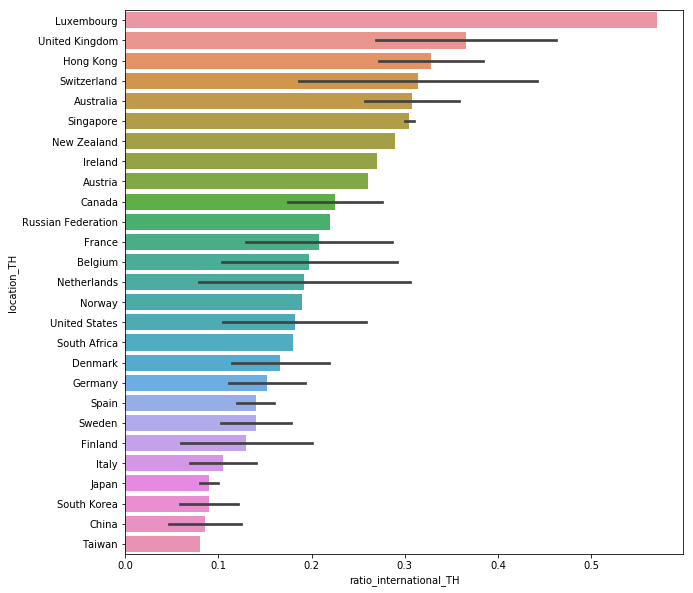

In [22]:
best_inter_country_TH = inter_country_df_TH.groupby("location_TH").mean().sort_values("ratio_international_TH", ascending=False)
best_inter_country_TH = best_inter_country_TH.rename(columns = {"ratio_international_TH": "ratio_international_TH_mean"})
best_inter_country_TH = best_inter_country_TH.reset_index()
best_inter_country_TH = TH_ranking.merge(best_inter_country_TH)
best_inter_country_TH = best_inter_country_TH.sort_values("ratio_international_TH_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax, y="location_TH", x="ratio_international_TH", data=best_inter_country_TH, orient="h", ci="sd")

### 2.d) Best by region

#### Best university in terms of ratio between faculty members and students (by region)

No data available - refer to 2.a)

#### Best university in terms of ratio of international students to total students (by region)

To get a sense for the best universities in each region, in terms of the ratio of international students to total students, we sort the THE data frame by the regions and the ratio.

We noticed, that the two universities listed below did not get a region assigned, because their countries were not listed as such in the QS ranking. We correct this by hand:

In [23]:
TH_ranking.loc["University of Luxembourg", "region_TH"] = "Europe"
TH_ranking.loc["Moscow State University", "region_TH"] = "Europe"

In [24]:
inter_region_df_TH = TH_ranking.set_index(["region_TH", "name_TH"])
inter_region_df_TH = inter_region_df_TH[["ratio_international_TH"]]
inter_region_df_TH = inter_region_df_TH.sort_values(["ratio_international_TH"], ascending=False)
inter_region_df_TH = inter_region_df_TH.sort_index(level="region_TH",sort_remaining=False)
inter_region_df_TH.head()

ratio_international_TH
region_TH name_TH                                                 
Africa    University of Cape Town                             0.18
Asia      University of Hong Kong                             0.42
          City University of Hong Kong                        0.35
          Chinese University of Hong Kong                     0.31
          Nanyang Technological University                    0.31

#### Best regions in terms of ratio between international students and total number of students

Here, we group the universities by region and aggregate the mean ratio of international students and total number of students and plot the resulting numbers in descending order. The displayed black error bars indicate the standard deviation of the ratios for all universities in a given region.

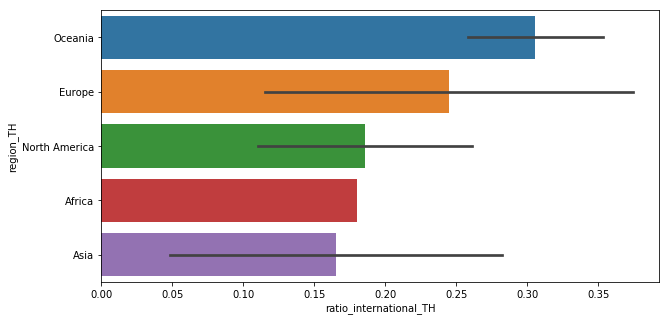

In [25]:
best_inter_region_TH = inter_region_df_TH.groupby("region_TH").mean().sort_values("ratio_international_TH", ascending=False)
best_inter_region_TH = best_inter_region_TH.rename(columns = {"ratio_international_TH": "ratio_international_TH_mean"})
best_inter_region_TH = best_inter_region_TH.reset_index()
best_inter_region_TH = TH_ranking.merge(best_inter_region_TH)
best_inter_region_TH = best_inter_region_TH.sort_values("ratio_international_TH_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, y="region_TH", x="ratio_international_TH", data=best_inter_region_TH, orient="h", ci="sd")

## 3. Merging the data frames

Due to the way we set the indices of the QS and the THE data frames, the task of merging can be achieved by a simple outer join on the indices. 

After the merge, the data frame now has more than 200 entries, because some universities are in one ranking but not in the other and could thus not find a fitting match.

In [26]:
merged = QS_ranking.join(TH_ranking, how='outer')
merged.head()

,country_QS,faculty_members_QS,inter_faculty_members_QS,inter_students_QS,rank_display_QS,ratio_faculty_QS,ratio_international_QS,region_QS,name_QS,total_students_QS,international_students_TH,location_TH,name_TH,rank_TH,ratio_international_TH,region_TH,total_students_TH
name,,,,,,,,,,,,,,,,,
Aalto University,Finland,1257.0,370.0,1831.0,=137,0.103482,0.150737,Europe,Aalto University,12147.0,2548.0,Finland,Aalto University,190,0.20,Europe,12744.0
Aarhus University,Denmark,2316.0,602.0,3762.0,119,0.088309,0.143445,Europe,Aarhus University,26226.0,3020.0,Denmark,Aarhus University,=109,0.12,Europe,25167.0
Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8450.0,United States,Arizona State University,=126,0.19,North America,44475.0
Australian National University,Australia,1600.0,927.0,5551.0,20,0.110788,0.384365,Oceania,Australian National University,14442.0,5595.0,Australia,Australian National University,48,0.35,Oceania,15986.0
Autonomous University of Barcelona,Spain,2187.0,230.0,3848.0,=195,0.068374,0.120303,Europe,Autonomous University of Barcelona,31986.0,5169.0,Spain,Autonomous University of Barcelona,=147,0.16,Europe,32309.0


## 4. Exploratory Data Analysis

To facilitate the analysis, we first parse the rankings of both universities and remove the "=" signs.

In [27]:
def rank_to_int(rank_obj):
    rank_str = re.sub("[^0-9^.]", "", rank_obj)
    if rank_str:
        return int(rank_str)
    else:
        return np.nan

merged['rank_QS'] = merged['rank_display_QS'].astype('str').apply(lambda x: rank_to_int(x))
merged = merged.rename(columns = {'rank_TH':'rank_display_TH'})
merged['rank_TH'] = merged['rank_display_TH'].astype('str').apply(lambda x: rank_to_int(x))

### Correlation between the QS rank and the THE rank

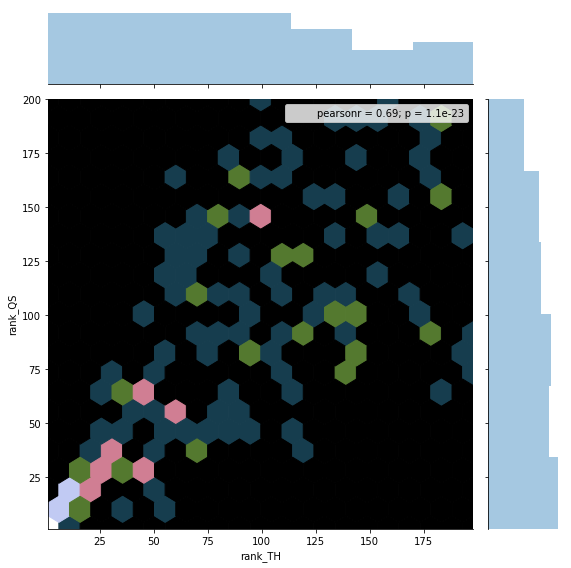

In [28]:
sns.jointplot(x='rank_TH', y='rank_QS', data=merged, kind='hex', cmap= 'cubehelix', size=8, gridsize=20)

Above the correlation between the university rankings according to QS and THE is plotted. It is very nicely visible, that there is strong correlation between universities with a high ranking in QS and universities with a high ranking in THE. The correlation gets weaker for lower universities.

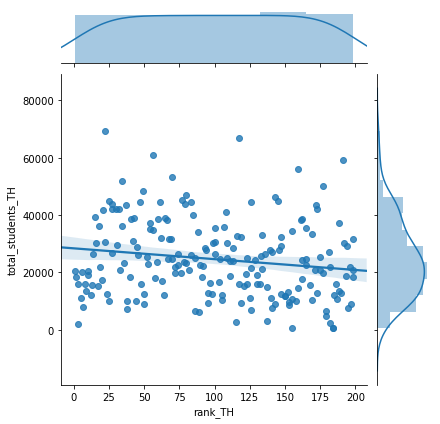

In [44]:
g = sns.JointGrid(x='rank_TH', y='total_students_TH', data=merged) 
g.plot_joint(sns.regplot, order=1) 
g.plot_marginals(sns.distplot)

Above the rank according to THE is plotted on the X-axis and the total number of students on the Y-axis. From this plot wer can learn, that the number of students is not a criterion for the quality of the university, because there is low correlation, but nevertheless notable is the fact, that the very best universities all have less than 20000 students.

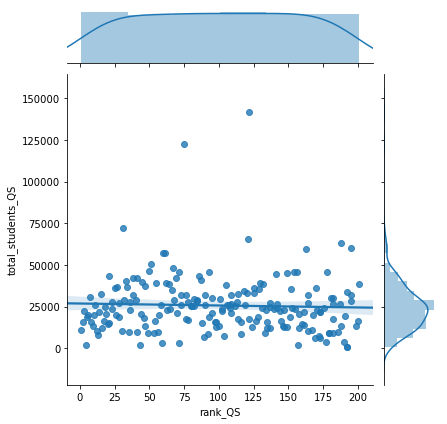

In [38]:
g = sns.JointGrid(x='rank_QS', y='total_students_QS', data=merged) 
g.plot_joint(sns.regplot, order=1) 
g.plot_marginals(sns.distplot)

Above the rank according to QS is plotted on the X-axis and the total number of students on the Y-axis. Here the correlation is even lower, than for the THE ranking, notable is also, that there are high scoring universities with more than 20000 students.

In [32]:
merged['inter_perc_QS'] = 100 * merged['inter_students_QS'] / merged['total_students_QS']
merged['inter_perc_TH'] = 100 * merged['international_students_TH'] / merged['total_students_TH']

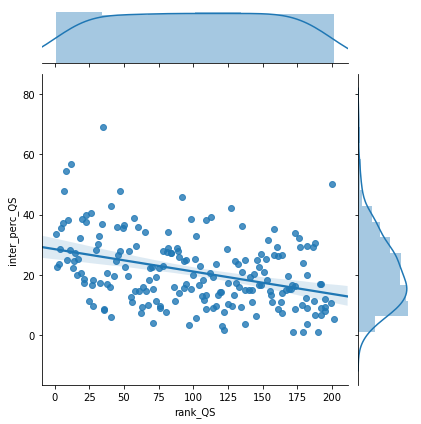

In [37]:
g = sns.JointGrid(x='rank_QS', y='inter_perc_QS', data=merged) 
g.plot_joint(sns.regplot, order=1) 
g.plot_marginals(sns.distplot)

Above the rank according to QS is plotted on the X-axis and the percentage of international students on the Y-axis. Here a notable negative correlation is visible, which indicates that universities, which have a high percentage of international students tend to be ranked higher. 

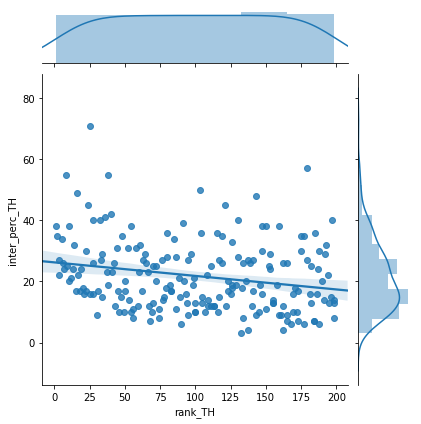

In [35]:
g = sns.JointGrid(x='rank_TH', y='inter_perc_TH', data=merged) 
g.plot_joint(sns.regplot, order=1) 
g.plot_marginals(sns.distplot)

Above the rank according to THE is plotted on the X-axis and the percentage of international students on the Y-axis. A notable negative correlation is visible, slightly lower than for the QS ranking, which indicates that universities, which have a high percentage of international students tend to be ranked higher. 

## 5. Overall Ranking

To find the overall best universities taking into account the QS and the THE rankings we decided to take the mean of both rankings. The ranking companies have many more factors at hand than we were able to take into account, so we decided to trust both equally, therefore the mean of the ranking indicates the most neutral way of finding a global best.

In [45]:
merged["avg_rank"] = merged[['rank_TH', 'rank_QS']].mean(axis=1)
top = merged.sort_values("avg_rank").head()
top[["avg_rank", "rank_QS", "rank_TH"]]

,avg_rank,rank_QS,rank_TH
name,,,
Stanford University,2.5,2.0,3.0
Massachusetts Institute of Technology,3.0,1.0,5.0
California Institute of Technology,3.5,4.0,3.0
University of Oxford,3.5,6.0,1.0
University of Cambridge,3.5,5.0,2.0
